In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/clay/userdata/title_generation


In [2]:
import torch
import shutil
from pathlib import Path
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from data_utils import ABCset, MeasureNumberSet, pack_collate, PitchDurSplitSet, FolkRNNSet, MeasureOffsetSet, read_yaml, MeasureEndSet, get_emb_total_size
from emb_trainer import EmbTrainer, EmbTrainerMeasure, EmbTrainerMeasureMRR
from emb_loss import get_batch_contrastive_loss, get_batch_euclidean_loss, clip_crossentropy_loss
from emb_utils import pack_collate_title_sampling_train, pack_collate_title_sampling_valid
from torch.nn import CosineEmbeddingLoss
import torch.nn.functional as F

import data_utils
import model_zoo
import emb_model
import emb_data_utils
import vocab_utils

import argparse
import wandb
import datetime

In [3]:
path = Path('pre_trained/measure_note_xl/')
if path.is_dir():
  yaml_path = list(path.glob('*.yaml'))[0]
  vocab_path = list(path.glob('*vocab.json'))[0]
  checkpoint_list = list(path.glob('*.pt'))
  checkpoint_list.sort(key= lambda x: int(x.stem.split('_')[-2].replace('iter', '')))
  checkpoint_path = checkpoint_list[-1]
  config = data_utils.read_yaml(yaml_path)
  data_param = config.data_params
  model_name = config.nn_params.model_name
  vocab_name = config.nn_params.vocab_name
  net_param = config.nn_params
  vocab = getattr(vocab_utils, vocab_name)(json_path= vocab_path)
  config = data_utils.get_emb_total_size(config, vocab)

In [4]:
score_dir = Path('abc_dataset/folk_rnn_abc_key_cleaned/')
dataset_name_ttl = "ABCsetTitle_22K"
dataset_abc = getattr(emb_data_utils, dataset_name_ttl)(score_dir, vocab_path, make_vocab=False, key_aug=data_param.key_aug, vocab_name=net_param.vocab_name, tune_length=100)
dataset_abc.vocab = vocab

Error in token measure_offset: <Beam "|">
Error in token measure_offset: <Beam "|">
Error in token measure_offset: <Beam "|">
Error in meas_offset_from_repeat_start: <Beam "|">
Error in token measure_offset: <Beam "|">
Error in meas_offset_from_repeat_start: <Tie "-">
Error in token measure_offset: <Beam "|">
Error in meas_offset_from_repeat_start: <Beam ":|">
Error in meas_offset_from_repeat_start: <Beam "|:">
Error in meas_offset_from_repeat_start: <Beam "|:">
Error in meas_offset_from_repeat_start: <Beam "|:">
Error in token measure_offset: <Beam "|">


In [5]:
model_cnn_reducedemb = getattr(emb_model, 'ABC_cnn_emb_Model')(trans_emb=None, vocab_size=vocab.get_size(), net_param=net_param, emb_size=256, hidden_size=128, emb_ratio=1)
model_ttl = getattr(emb_model, 'TTLembModel')(emb_size=256)

# load pretrained model
model_cnn_reducedemb.load_state_dict(torch.load('/home/clay/userdata/title_generation/saved_models/0130_06_transfer_best/measurenote_0.pt')['model'])
model_ttl.load_state_dict(torch.load('/home/clay/userdata/title_generation/saved_models/0130_06_transfer_best/ttlemb_0.pt')['model'])

model_cnn_reducedemb
model_ttl

TTLembModel(
  (layer): Sequential(
    (0): Linear(in_features=384, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=128, out_features=256, bias=True)
  )
)

In [6]:
torch.manual_seed(42)

trainset, validset = torch.utils.data.random_split(dataset_abc, [int(len(dataset_abc)*0.9), len(dataset_abc) - int(len(dataset_abc)*0.9)], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(trainset, batch_size=7000, collate_fn=pack_collate_title_sampling_train, shuffle=True) #collate_fn=pack_collate)
valid_loader = DataLoader(validset, batch_size=7000, collate_fn=pack_collate_title_sampling_valid, shuffle=False) #collate_fn=pack_collate)


In [7]:
for batch in train_loader:
  melody, title, measure_numbers = batch
  train_abc_emb = model_cnn_reducedemb(melody)
  train_ttl_emb = model_ttl(title)
  

In [8]:
for batch in valid_loader:
  melody, title, measure_numbers = batch
  valid_abc_emb = model_cnn_reducedemb(melody)
  valid_ttl_emb = model_ttl(title)

In [9]:
train_abc_emb = F.normalize(train_abc_emb, dim=1)
train_abc_cosim = torch.matmul(train_abc_emb, train_abc_emb.T)
train_ttl_emb = F.normalize(train_ttl_emb, dim=1)
train_ttl_cosim = torch.matmul(train_ttl_emb, train_ttl_emb.T)
train_cosim = torch.matmul(train_abc_emb, train_ttl_emb.T)

In [14]:
len(train_abc_cosim)//2

2828

In [11]:
train_abc_cosim_list = []
train_ttl_cosim_list = []
train_cosim_list = []

for i in range(1, len(train_abc_cosim)//2):
  #train_abc_cosim_list.append((sum(train_abc_cosim[i]) -1) / len(train_abc_cosim[i] -1))
  #train_ttl_cosim_list.append((sum(train_ttl_cosim[i]) -1) / len(train_ttl_cosim[i] -1))
  train_cosim_list.append((sum(train_cosim[i]) -1) / len(train_cosim[i] -1))


In [15]:
for i in range(len(train_abc_cosim)//2, len(train_abc_cosim)):
  #train_abc_cosim_list.append((sum(train_abc_cosim[i]) -1) / len(train_abc_cosim[i] -1))
  #train_ttl_cosim_list.append((sum(train_ttl_cosim[i]) -1) / len(train_ttl_cosim[i] -1))
  train_cosim_list.append((sum(train_cosim[i]) -1) / len(train_cosim[i] -1))

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# convert tensors to a numpy array
train_abc_cosim_arr = np.array([np.array(tensor.cpu().detach()) for tensor in train_abc_cosim_list])
train_ttl_cosim_arr = np.array([np.array(tensor.cpu().detach()) for tensor in train_ttl_cosim_list])
train_cosim_arr = np.array([np.array(tensor.cpu().detach()) for tensor in train_cosim_list])

# flatten the array
# arr = train_abc_cosim_arr.flatten()

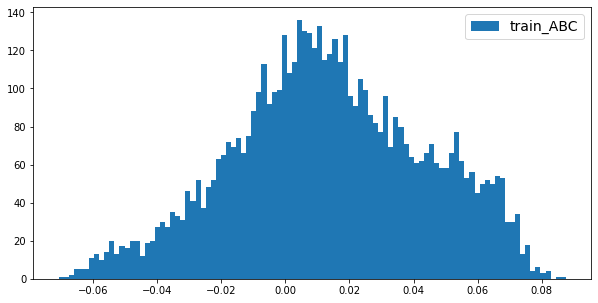

In [25]:
# plot the histogram
plt.figure(figsize=(10, 5))
plt.hist(train_abc_cosim_arr, bins=100, label="train_ABC")
plt.legend(fontsize=14)
plt.show()

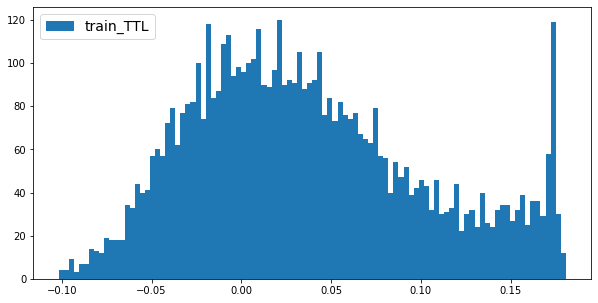

In [26]:
# plot the histogram
plt.figure(figsize=(10, 5))
plt.hist(train_ttl_cosim_arr, bins=100, label="train_TTL")
plt.legend(fontsize=14)
plt.show()

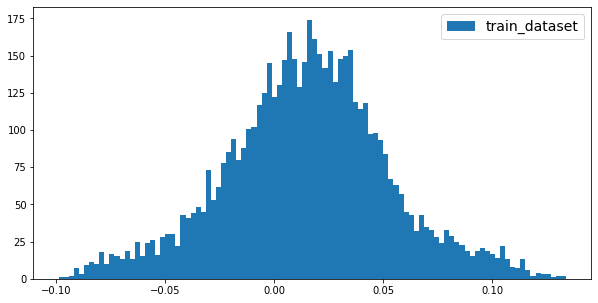

In [17]:
# plot the histogram
plt.figure(figsize=(10, 5))
plt.hist(train_cosim_arr, bins=100, label="train_dataset")
plt.legend(fontsize=14)
plt.show()